In [7]:
import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F

from PIL import Image, ImageOps, ImageDraw, ImageDraw2, ImageFont

In [2]:
!nvidia-smi

Fri Jul  8 17:28:49 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 515.48.07    Driver Version: 515.48.07    CUDA Version: 11.7     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  Off  | 00000000:01:00.0 Off |                  N/A |
|  0%   39C    P8    14W / 215W |    162MiB /  8192MiB |      1%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Support Code

In [34]:
# A Convenience method to take a triple of three floats and an image to give an appropriately formatted output image.

def sample_image_from_triplet(pil_image:Image, position_triplet, tensor_width:int):
    """
    Create a PIL of size tensor_width,tensor_width from the given position triplet, x, y, zoom.
    x, y, and zoom should all be in the 0-1 range.
    zoom behaves opposite what one would normally expect.  At 1.0, the image width is scaled down to the tensor width.
    That is, 1.0 zoom -> full image in tensor.
    At 0.5 -> half of the image fits in the tensor.  0.1 -> 10% of the image goes to the tensor.
    The x and y are similar to UV coordinates, in that they describe the offset horizontally and vertically for the focus.
    """
    #Image.transform(size, method, data=None, resample=Resampling.NEAREST, fill=1, fillcolor=None)
    #Transforms this image. This method creates a new image with the given size, and the same mode as the original, and copies data to the new image using the given transform.
    x, y, zoom = position_triplet
    img_width, img_height = pil_image.size
    sample_width = img_width*zoom
    sample_height = img_height*zoom
    nw_sw_se_ne = [
        x*img_width, y*img_height,
        x*img_width, y*img_height + sample_height,
        x*img_width + sample_width, y*img_height + sample_height,
        x*img_width + sample_width, y*img_height
    ]
    sample = pil_image.transform((tensor_width, tensor_width), Image.Transform.QUAD, data=nw_sw_se_ne)
    # From source: quadrilateral warp.  data specifies the four corners given as NW, SW, SE, and NE.
    return sample

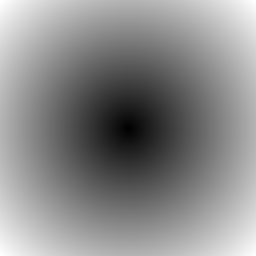

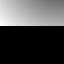

In [39]:
# Testing:
display(Image.radial_gradient('L'))
display(sample_image_from_triplet(Image.radial_gradient('L'), (0.0, 0.8, 0.5), 64))

# Training Data:

In [ ]:
from torch.utils.data import Dataset


class BaseTextDataset(Dataset):
    def __init__(self, target_width: int = 128, target_height: int = 128):
        super(BaseTextDataset, self).__init__()
        self.resize_op = transforms.Resize(size=[target_height, target_width])
        self.target_width = target_width
        self.target_height = target_height
        self.font_choices = None
        self.font_directory = "fonts/*.*tf"
        self.font_sizes = [12, 14, 16, 24, 32, 48, 72]
        self.text_noise = 0.1
        self.downsample_image_before_crop = False
        self.random_text_max_translation = 0
        self.random_text_rotation = True
        self.random_text_length = 17
        self.random_text_mask_dilation = 5

        with open(os.path.join("text_images_mscoco_2014", "image_data_by_name.json"), 'rt') as fin:
            self.img_mask_data = json.load(fin)

        # Listdir will give us the filenames, but we want the full paths for loading.
        #self.textless_images = sorted(os.listdir(os.path.join("text_images_mscoco_2014", "no_text")))
        self.textless_images = glob(os.path.join("text_images_mscoco_2014", "no_text", "*"))
        self.mintext_images = glob(os.path.join("text_images_mscoco_2014", "no_legible_text", "*"))
        self.sometext_images = glob(os.path.join("text_images_mscoco_2014", "some_legible_text", "*"))
        self.alltext_images = glob(os.path.join("text_images_mscoco_2014", "all_legible_text", "*"))

        self.image_center = (self.target_width//2, self.target_height//2)

    def __len__(self):
        return len(self.textless_images)

    def __getitem__(self, index):
        if index >= len(self.alltext_images):
            img, mask, _, _ = self.generate_image_mask_pair(index % len(self.textless_images))
        else:
            img, mask = self.get_dataset_image(index)
        img = torch.Tensor(numpy.asarray(img) / 255.0)
        mask = torch.Tensor(numpy.asarray(mask) / 255.0)
        return img, mask

    def make_validation_set(self, items=16):
        validation_images = list()
        validation_masks = list()
        for i in range(items):
            img, mask = self.get_dataset_image(i, validation_set=True)
            # Can't generate images because that will trigger font loading and we need to wait for the workers to spin up.
            #	img, mask = self.generate_image(i)
            validation_images.append(numpy.asarray(img)/255.0)
            validation_masks.append(numpy.asarray(mask)/255.0)
        validation_images = torch.Tensor(numpy.asarray(validation_images))
        validation_masks = torch.Tensor(numpy.asarray(validation_masks))
        return validation_images, validation_masks

    # Pull from a real dataset.
    def get_dataset_image(self, idx: int, validation_set: bool = False):
        """Return a pair of images, one with the text and one with the mask, as generated by MSCOCO."""
        # Our model transform does the swap to channels first, so we don't need to fret.
        if validation_set:
            img_fullpath = self.sometext_images[idx]
        else:
            img_fullpath = self.alltext_images[idx]
        img_filename = os.path.split(img_fullpath)[-1]
        assert img_filename in self.img_mask_data
        sample_annotation = """{
            'mask': [197.5, 108.0, 196.5, 118.0, 241.5, 120.2, 241.9, 109.6],
            'class': 'machine printed',
            'bbox': [196.5, 108.0, 45.4, 12.2],
            'image_id': 390310,
            'id': 117115,
            'language': 'english',
            'area': 461.74,
            'utf8_string': 'BARNES',
            'legibility': 'legible'}]}
        """
        img = Image.open(img_fullpath).convert('RGB')
        # Make the mask image the size of the original so the annotations match up, then we can crop later.
        mask = Image.new('L', img.size, color=0)
        d = ImageDraw.Draw(mask)
        mean_center_x = 0
        mean_center_y = 0
        # Draw all bounding polygons:
        for annotation in self.img_mask_data[img_filename]['annotations']:
            d.polygon(annotation['mask'], fill='white')
            text_bounding_box = annotation['bbox']
            bb_x, bb_y, bb_w, bb_h = text_bounding_box
            center_x = bb_x + (bb_w//2)
            center_y = bb_y + (bb_h//2)
            mean_center_x += center_x
            mean_center_y += center_y
        center_x = mean_center_x // len(self.img_mask_data[img_filename]['annotations'])
        center_y = mean_center_x // len(self.img_mask_data[img_filename]['annotations'])
        # DEBUG!  Select one fo the bounding polygons to focus on at random.
        annotation = random.choice(self.img_mask_data[img_filename]['annotations'])
        center_x = annotation['bbox'][0] + annotation['bbox'][2]//2
        center_y = annotation['bbox'][1] + annotation['bbox'][3]//2
        if self.downsample_image_before_crop:
            # Most of the images are 640x480-ish, so if we can resize to around 256x256 and then crop we will get more in frame.
            img.resize((img.size[0]//2, img.size[1]//2))
            mask.resize((mask.size[0]//2, mask.size[1]//2))
            center_x = center_x // 2  # Don't forget to move these!
            center_y = center_y // 2
        # Try and crop around the center.
        left = max(0, center_x - self.target_width//2)
        top = max(0, center_y - self.target_height//2)
        right = left + self.target_width
        bottom = top + self.target_height
        crop_box = (left, top, right, bottom)
        img_crop = img.crop(crop_box)
        mask_crop = mask.crop(crop_box)

        return img_crop, mask_crop

    def get_random_font(self):
        """We need to lazy load the fonts because the dataset loaders are assumed to run out of thread and ImageFont is not serializable."""
        if self.font_choices is None:
            self.font_choices = list()
            for font_filename in iglob(self.font_directory):
                for font_size in self.font_sizes:
                    self.font_choices.append(ImageFont.truetype(font_filename, font_size))
        return random.choice(self.font_choices)

    def random_text_image(self):
        """Generate randomly oriented white text on a black background.  RGB image.  Can be used as a mask."""
        # TODO: This isn't a pretty thing, but it works.
        text = "".join(random.choice(string.ascii_letters + string.punctuation + " " * 4) for _ in range(self.random_text_length))
        text_image = Image.new("RGB", (self.target_width, self.target_height), "black")
        d = ImageDraw.Draw(text_image)
        # d.line(((0, 100), (200, 100)), "gray")
        # d.line(((100, 0), (100, 200)), "gray")
        if self.random_text_max_translation > 0:
            # Note that this translates before rotating, so our offset might be a little weird.
            text_position = (
                self.image_center[0] + random.randint(-self.random_text_max_translation, self.random_text_max_translation),
                self.image_center[1] + random.randint(-self.random_text_max_translation, self.random_text_max_translation),
            )
        else:
            text_position = self.image_center
        d.text(text_position, text, fill="white", anchor="mm", align="center", font=self.get_random_font())
        if self.random_text_rotation:
            rotation = random.randint(0, 359)
        else:
            rotation = 0
        text_image = text_image.rotate(rotation)
        return text_image, text, rotation

    def generate_image_mask_pair(self, index):
        # We assume we're starting with PIL images for everything AND that they have no text.
        img_pil = Image.open(self.textless_images[index]).convert('RGB')

        # Randomly mutate the input image.
        if random.choice([False, True]):
            img_pil = img_pil.transpose(Image.FLIP_LEFT_RIGHT)
        if random.choice([False, True]):
            img_pil = img_pil.transpose(Image.FLIP_TOP_BOTTOM)
        if random.choice([False, True]):
            img_pil = img_pil.rotate(random.randint(0, 359))

        # If the image is big enough for a random crop, do it.
        if img_pil.size[0] > self.target_width and img_pil.size[1] > self.target_height:
            left = random.randint(0, img_pil.size[0]-1-self.target_width)
            top = random.randint(0, img_pil.size[1] - 1 - self.target_height)
            img_pil = img_pil.crop((left, top, left+self.target_width, top+self.target_height))
        else:
            img_pil = img_pil.resize((self.target_width, self.target_height))

        # Generate some random text:
        text_image_mask, text, text_rotation = self.random_text_image()
        text_image_mask = text_image_mask.convert('L')

        # Glorious hack to make a red mask:
        # red_channel = img_pil[0].point(lambda i: i < 100 and 255)

        # Draw the text image on top of our sample image.
        # if (red * 0.299 + green * 0.587 + blue * 0.114) > 186 use  # 000000 else use #ffffff
        total_color = [0, 0, 0]
        total_pixels = 0
        for y in range(self.target_height):
            for x in range(self.target_width):
                mask = text_image_mask.getpixel((x, y))
                if mask > 128:
                    px = img_pil.getpixel((x, y))
                    total_color[0] += px[0]
                    total_color[1] += px[1]
                    total_color[2] += px[2]
                    total_pixels += 1

        # In the off chance we have a completely blank image, save some compute.
        if total_pixels > 0:
            avg_r = total_color[0]//total_pixels
            avg_g = total_color[1]//total_pixels
            avg_b = total_color[2]//total_pixels

            # Default to light color...
            text_color = [random.randint(150, 255), random.randint(150, 255), random.randint(150, 255)]
            if (avg_r*0.299 + avg_g*0.587 + avg_b * 0.114) > 125:  # 186 comes from the algorithm but is a little hard to see.
                # Unless our image is bright, in which case use dark color.
                text_color = [random.randint(0, 75), random.randint(0, 75), random.randint(0, 75)]
            # Have to convert text color to a hex string.  :rolleges:
            text_color = f"#{text_color[0]:02X}{text_color[1]:02X}{text_color[2]:02X}"
            # Make a rectangle of this color and paste it in with an image mask.
            text_color_block = Image.new("RGB", (self.target_width, self.target_height), color=text_color)
            # Maybe add noise to the color block.
            if self.text_noise > 0:
                pass
            img_pil.paste(text_color_block, (0,0), text_image_mask)

        # Now dilate the text_image_mask to simulate highlighting a block.
        if self.random_text_mask_dilation > 0:
            text_image_mask = text_image_mask.filter(ImageFilter.MaxFilter(self.random_text_mask_dilation))

        return img_pil, text_image_mask, text, text_rotation

# Model Architecture:

In [ ]:
import string

CHAR_TO_IDX = {chr(idx):idx for idx in range(ord(' '), ord('~')+1)}
CHAR_TO_IDX['\n'] = len(CHAR_TO_IDX)+1
IDX_TO_CHAR = {idx:char for idx, char in CHAR_TO_IDX.items()}  # Could use list.

class OCRRNN(nn.Module):
    def __init__(self, rnn_latent_size:int, num_layers:int, fov_wh:int = 64):
        #self.attention = (0, 0, 1.0)  # xPos 0-1, yPos 0-1, zoom 0-1.  1.0 = whole image.  0.1 = 10% width.
        #self.active_image
        self.rnn_latent_size = rnn_latent_size
        self.image_fov = fov_wh  # Technically not 'field of view' in the rendering sense.  Just width/height.
        self.num_layers = num_layers
        self.rnn = nn.GRU(input_size=fov_wh*fov_wh, hidden_size=rnn_latent_size, num_layers=num_layers, batch_first=True)
        self.focus_head = nn.Linear(rnn_latent_size, 3)
        self.text_head = nn.Linear(rnn_latent_size, len(CHAR_TO_IDX))
        
    def forward(self, input_state, hidden_state):
        """
        >>> rnn = nn.GRU(10, 20, 2)
        >>> input = torch.randn(5, 3, 10)
        >>> h0 = torch.randn(2, 3, 20)
        >>> output, hn = rnn(input, h0)
        """
        # Convert the PIL image into a tensor, cropped around the appropriate zoom levels.
        embedded = self.embedding(input).view(1, 1, -1)
        output = embedded
        output, hidden = self.gru(output, hidden)
        return hidden, output, self._new_position_from_output(output), self._char_distribution_from_output(output)
    
    def _char_distribution_from_output(self, output):
        x = self.text_head(output)
        x = F.softmax(x)
        return x
    
    def _new_position_from_output(self, output):
        return self.focus_head(output)

In [9]:
ord(' ')

32

In [10]:
ord('~')

126

In [4]:
ord('\n')

10